# Расчет затрат энергии в распределенной модели по Спенсеру (2012)

 - используем `NEURON`, но всю модель делаем из `Python` (кроме `NMODL`-файлов)

In [1]:
from itertools import chain
from neuron import h, gui

%pylab inline
style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
R = 8314.4  # Universal gaz constant, mJ / mole*K
F = 96485   # Faraday constant [C/mol]
F_ATP = 50 # kJ/mol *Интересно*

avogadro = 6.022e23 # N_a

In [3]:
# number of segments per dendrite should be large to allow for precise synapse location
Ndend = 4

h.celsius = 37.0

all_currents = ['leak', 'nas', 'kltoz', 'khtoz', 'hcno'] # Есть еще медленный Ca2+ 
                                                         # (Статья Oertel et al про Ca-токи в октопус нейронах)

soma = h.Section(name='soma')
ax_stub = h.Section(name='ax_stub')
ax_init = h.Section(name='ax_init')
dendrites = [h.Section(name='dend-%d'%i) for i in range(Ndend)]

# def init_octopus(Ldend=250, Ndendseg=201, Eleak = -62.0):
def init_octopus(Ldend=280, Ndendseg=201, Eleak = -62.0):
    # Soma
    soma.L, soma.diam = 25, 25
    soma.nseg = 1
    
    # Axon
    ax_stub.diam = ax_init.diam = 3.0
    ax_stub.L = 30
    ax_init.L = 2
    ax_init.connect(ax_stub, 1, 0)
    ax_stub.connect(soma, 0, 0)
    
    # Dendrites
    for d in dendrites:
        d.diam = 3
        d.L = Ldend
        d.nseg = Ndendseg
        d.connect(soma, 1, 0) # dends(0) connected to soma(1)
        
    for sec in h.allsec():
        sec.Ra = 100  # Spencer
        sec.cm = 0.9      # Spencer
        for cur in all_currents:
            sec.insert(cur)
        for seg in sec:
            seg.leak.erev = Eleak
            seg.leak.g = 0.002  # Spencer
            seg.hcno.eh = -38 # Spencer
            
            seg.nas.gbar = 0
            seg.hcno.gbar = 0
            seg.kltoz.gbar = 0
            seg.khtoz.gbar = 0
            
        sec.ena = 55.0
        sec.ek = -70.0
    
    # ... there must be a more compact way...
    for seg in ax_init:
        seg.nas.gbar = 4.2441

    for seg in soma:
        seg.kltoz.gbar = 0.0407
        seg.khtoz.gbar = 0.0061
        seg.hcno.gbar = 0.0076
    
    for seg in chain(*dendrites):
        seg.kltoz.gbar = 2.7e-3 # Table 3 Spencer 2012
        seg.hcno.gbar = 0.6e-3 # Table 3 Spencer 2012

init_octopus()

In [4]:
# Площадь поверхности распределенной и точечной моделей
Area = (soma(.5).area()+4*201*dendrites[1](.5).area()+ ax_init(.5).area() + ax_stub(.5).area())*1e-8
Area_point = 1.2*1e-5
print '%02.2e, point_modle: %02.2e'%(Area, Area_point)

1.28e-04, point_modle: 1.20e-05


## Energy calc

In [5]:
def split_mixed(v, gm, erev, ek=-70,ena=55):
    gratio = float((ena-erev))/(erev-ek)
    denom = (v*(gratio+1) - gratio*ek - ena)
    if (abs(v-erev) < 1):
        gnah = gm/(gratio + 1)
    else: 
        gnah = gm*(v-erev)/denom
    inah = gnah*(v-ena)
    ikh = gratio*gnah*(v-ek)
    return inah, ikh


def ratp_attwell(V, Rin, Ena = 55, Ek = -70):
    "returns resting ATP consumption rate in pmol ATP/s"
    # I take Rm in MOhms and V in mV
    # Thus, result is in nmole/sec
    out = (Ena-V)*(V-Ek)/(F*Rin*(V + 2*Ena - 3*Ek))
    return out*1e3 # nmol -> pmol

def pmol2molecules(x):
    return x*1e-12*avogadro

def atp2J(nATP):
    "Convert pmol ATP/s to energy usage in pJoule/s"
    return F_ATP * nATP * 1e3
    pas

def J2atp(nJ):
    "convert from Joule/s to mol ATP/s"
    return (nJ/F_ATP)*1e-3


def mouj_Erate2(seg, erev_ih = -38):
    v = seg.v
    acc = 0.0
    inah, ikh = split_mixed(seg.v, seg.thegna_hcno, erev_ih, seg.ek, seg.ena) # раскладываем Ih на компоненты
    ina = seg.ina + inah      # суммарный ток Na
    ik = seg.ik + ikh         # суммарный ток K
    
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    
    acc += ina*(v-seg.ena)
    acc += ik*(v-seg.ek)
    acc += seg.i_leak*(v-seg.erev_leak) # Ну и утечка, хотя вклад от нее минимальный.
    acc = acc*seg.area()*factor
    
    acc_h = (abs(inah*(v-seg.ena)) + abs(ikh*(v-seg.ek)))*seg.area()*factor
    acc_klt = abs(seg.ik_kltoz*(v-seg.ek))*seg.area()*factor
    acc_cap = abs(seg.i_cap*v)
    
    return acc, acc_h, acc_klt, acc_cap

def synaptic_curr2pJ(syn,seg):
    # syn.g is in uS, syn.i is in nA, erate is in pJ/s
    v  = seg.v
    g = syn.g
    ina, ik = split_mixed(v, g, 0, seg.ek, seg.ena)
    erate = ina*(v-seg.ena) + ik*(v-seg.ek)
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    return erate*seg.area()*factor # earlier: print erate

## Run control

In [6]:
# stim = h.IClamp(0.5, sec=soma)
# stim.delay = 100
# stim.amp= 0
# stim.dur = 10

In [7]:
afib = h.NetStim()
# def set_netst_params(interval=3,start=200,num=10,noise=0.0)
afib.interval = 3 # ms 
afib.start = 200 # ms
afib.number = 1 # number of spikes
afib.noise = 0.0 # no randomness so far
# Использовать .noise для иммитации спонтанной активности ВСН?

In [8]:
Nsyn_per_dend = 17
gsyn1 = 2e-3 # 2nS -> microsiemens
gsyn_sup = 30e-3 # 2nS -> microsiemens

tau_rise = 0.07 
tau_decay = 0.34 

fulldelay = 0.29
# Больше синапсов -- сильнее впсп --> можно чаще генерить пд? 
# +++ меньше чувствительность к тонотопической организации синапсов?

In [9]:
# Варианты delays с разными краями
a=array(sorted(arange(0,fulldelay,fulldelay/Nsyn_per_dend), reverse=True))
b=arange(fulldelay,0,-fulldelay/Nsyn_per_dend)
c=delay = linspace(0,fulldelay,Nsyn_per_dend)[::-1]
print a, '\n', b, '\n', c

[ 0.27294118  0.25588235  0.23882353  0.22176471  0.20470588  0.18764706
  0.17058824  0.15352941  0.13647059  0.11941176  0.10235294  0.08529412
  0.06823529  0.05117647  0.03411765  0.01705882  0.        ] 
[ 0.29        0.27294118  0.25588235  0.23882353  0.22176471  0.20470588
  0.18764706  0.17058824  0.15352941  0.13647059  0.11941176  0.10235294
  0.08529412  0.06823529  0.05117647  0.03411765  0.01705882] 
[ 0.29      0.271875  0.25375   0.235625  0.2175    0.199375  0.18125
  0.163125  0.145     0.126875  0.10875   0.090625  0.0725    0.054375
  0.03625   0.018125  0.      ]


In [10]:
def add_synapses(order='ordered'):
    synapses = []
    step = fulldelay/Nsyn_per_dend # this is the TIME step
    for d in dendrites:
        delays = linspace(0,fulldelay,Nsyn_per_dend)[::-1] # моменты времени, при кот. активируются синапсы
        locations = sorted(array(delays)/0.29) # координаты вдоль дендрита, где размещаются синапсы

        if order == 'ordered':
            locations = locations
        if order == 'inverse':
            locations = sorted(locations, reverse=True)
        if order == 'random':
            locations = list(permutation(array(locations)))
            
        for k in xrange(Nsyn_per_dend): # xrange -> create but not save
            # to be refined later...
            #delay = fulldelay*float(k)/Nsyn_per_dend
            syn = h.Exp2Syn(locations[k], sec=d) 
            syn.tau1 = tau_rise # rise time
            syn.tau2 = tau_decay # decay time
            con  = h.NetCon(afib, syn, 0, delays[k], gsyn1)
            synapses.append((syn, con, d(locations[k])))
    return synapses

In [11]:
rc('font', family='Arial')

In [12]:
h.dt = 0.01
tstop = 500

h.v_init = -60.6

#for con in connections:
#    con.weight[0] = gsyn1*30

def initialize():
    h.finitialize(h.v_init)
    h.fcurrent()

def integrate_M(syns):

    keepvar = ['t','soma.v','axon.v',
               'soma.erate','axon.erate','dend.erate', 'syn.erate'] 
    keepvar_h_klt = ['t', 'tot_h.erate', 'tot_klt.erate',
                    'soma_h.erate','soma_klt.erate','dends_h.erate','dends_klt.erate'] 
    keepvar_cape = ['t','soma_cape', 'ax_cape', 'dend_cape']
    
    out = {key:[] for key in keepvar} # Энергия по компартментам
    out_h_klt = {key:[] for key in keepvar_h_klt} # Энергия h и klt токов по компартментам
    out_cap = {key:[] for key in keepvar_cape}
    
    while h.t < tstop:
        h.fadvance()
        #isyn = np.sum([syn.i for syn in synapses])
        
        syn_erate = np.sum([synaptic_curr2pJ(s,dseg) for s,c,dseg in syns]) # syns = synapses <- add_synapses()
        soma_erate = mouj_Erate2(soma(0.5))[0]
        dend_erate = np.sum([mouj_Erate2(seg)[0] for seg in chain(*dendrites)])
        axon_erate = np.sum([mouj_Erate2(seg)[0] for seg in chain(ax_init, ax_stub)])
        
        tot_h =   mouj_Erate2(soma(0.5))[1] + np.sum([mouj_Erate2(seg)[1] for seg in chain(*dendrites)]) + np.sum([mouj_Erate2(seg)[1] for seg in chain(ax_init, ax_stub)])
        tot_klt = mouj_Erate2(soma(0.5))[2] + np.sum([mouj_Erate2(seg)[2] for seg in chain(*dendrites)]) + np.sum([mouj_Erate2(seg)[2] for seg in chain(ax_init, ax_stub)])
        soma_h = mouj_Erate2(soma(0.5))[1] 
        soma_klt = mouj_Erate2(soma(0.5))[2] 
        dends_h = np.sum([mouj_Erate2(seg)[1] for seg in chain(*dendrites)])
        dends_klt = np.sum([mouj_Erate2(seg)[2] for seg in chain(*dendrites)])
        
        soma_cape = mouj_Erate2(soma(.5))[3]
        ax_cape = np.sum([mouj_Erate2(seg)[3] for seg in chain(*dendrites)])
        dend_cape = np.sum([mouj_Erate2(seg)[3] for seg in chain(ax_init, ax_stub)])

#         теперь тут циклы:
        lov = [h.t, soma.v, ax_init.v, soma_erate, axon_erate, dend_erate, syn_erate]
        #lov = List Of Vars
        for key in keepvar:
            j = keepvar.index(key)
            out[key].append(lov[j])
        
        lov2 = [h.t, tot_h, tot_klt, soma_h, soma_klt, dends_h, dends_klt]
        for key in keepvar_h_klt:
            j = keepvar_h_klt.index(key)
            out_h_klt[key].append(lov2[j])
       
        lov3 = [h.t, soma_cape, ax_cape, dend_cape]
        for key in keepvar_cape:
            j = keepvar_cape.index(key)
            out_cap[key].append(lov3[j])

    a1 = {key:np.array(vec) for key,vec in out.items()}
    a2 = {key:np.array(vec) for key, vec in out_h_klt.items()}
    a3 = {key:np.array(vec) for key, vec in out_cap.items()}
    
    return a1, a2, a3

def go(syns):
    initialize()
    traj, h_klt, cape = integrate_M(syns)
    return traj, h_klt, cape
    
def plot_traj(traj): # pic ПД, energy expenditure in compartments + synaptic -- time. ***traj = go(syns)[0]***
    f, axs = subplots(2,1,sharex=True, figsize=(14,9),)
    #axs = [axs]
    axs[0].plot(traj['t'], traj['axon.v'],'r-',lw=0.5,label='axon.v')
    axs[0].plot(traj['t'], traj['soma.v'],'b-',label='soma.v')
    axs[0].set_ylabel('$V_m$', fontsize='x-large', alpha=1.0)
    axs[0].set_title('$V_m(t)$')
    axs[0].legend()
    
    axs[1].plot(traj['t'], traj['soma.erate'], '-', label='soma.erate')
    axs[1].plot(traj['t'], traj['dend.erate'], '-', label='dend.erate')
    axs[1].plot(traj['t'], traj['axon.erate'], '-', label='axon.erate')
    axs[1].plot(traj['t'], traj['syn.erate'], '-', color='orange', label='syn.erate')
    axs[1].set_xlabel('$time, ms$', size='x-large')
    axs[1].set_ylabel('$E_{rate}$', size='x-large')
    axs[1].set_title('$Erate(t)$')
    axs[1].legend()
#     Любопытно посмотреть график в координатах, типа, Ikl-Ih.

def plot_traj2(traj1, traj2): # pic ПД, Somatic Ih, Ikl -- time
    f, axs = subplots(2,1,sharex=True, figsize=(6,7), )
    #axs = [axs]
#     axs[0].plot(traj1['t'], traj1['axon.v'],'r-',lw=0.5,label='аксон')
#     axs[0].plot(traj1['t'], traj1['soma.v'],'b-',label='сома')
#     axs[0].legend()
#     axs[0].set_ylabel('Мембранный потенциал, мВ')
    
    axs[0].plot(traj1['t'], traj1['soma.erate'], '-', label=u'сома')
    axs[0].plot(traj1['t'], traj1['dend.erate'], '-', label=u'дендриты')
    axs[0].plot(traj1['t'], traj1['axon.erate'], '-', label=u'аксон')
#     axs[0].plot(traj1['t'], traj1['syn.erate'], '-', color='orange', label=u'синаптические токи')
    axs[0].legend()
    axs[0].set_title(u'Энергозатраты по компартментам')
    axs[0].set_ylabel(u'Е, пДж/с')
    axs[0].set_ylim(-5,600)
    text(200.5, 0, 'hello!')
    
    
    axs[1].plot(traj2['t'], traj2['soma_h.erate'], '-', label=u'сома, I$_h$')
#     axs[1].plot(traj2['t'], traj2['dends_h.erate'], '-', label=u'дендриты, I$_h$')
#     axs[1].plot(traj2['t'], traj2['tot_h.erate'], '-', label=u'общий, I$_h$')
    axs[1].plot(traj2['t'], traj2['soma_klt.erate'], '-', label=u'сома, I$_{kl}$')
#     axs[1].plot(traj2['t'], traj2['dends_klt.erate'], '--', label=u'дендриты, I$_{kl}$')
#     axs[1].plot(traj2['t'], traj2['tot_klt.erate'], '--', label=u'общий, I$_{kl}$')
#     axs[1].plot(traj2['t'], traj2[''])
    axs[1].legend(loc=7)
#     axs[1].set_title(u'Энергозатраты на соматические токи I$_h$ и I$_{kl}$')
    axs[1].set_ylabel(u'Е, пДж/с')
    axs[1].set_xlabel(u'время, мс')


In [13]:
s = add_synapses()
h.cvode_active(1)
h.cvode.atol(1e-4)

0.0001

In [16]:
# traj, h_klt, cape = go(s) #-> нет ПД
traj, h_klt, cape = go(add_synapses()) # -> ПД

(200, 202)

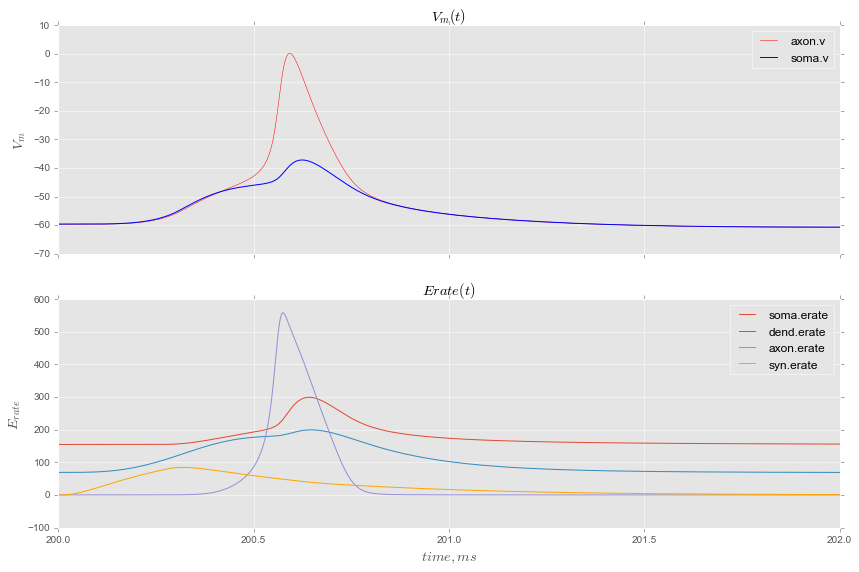

In [17]:
plot_traj(traj)
xlim(200,202)

In [18]:
tstop = 500
# Записать изменения ионных токов:
def currents():
    soma_currents = ['t','klt', 'kht', 'h',  'leak']
    dends_currents = ['t','klt', 'h', 'leak'] # +['syn']
    ax_currents = ['t','na', 'leak']
    total_currents = ['t','klt', 'kht','h', 'na', 'leak']
    
    soma_out = {key: [] for key in soma_currents}
    dends_out = {key: [] for key in dends_currents}
    ax_out = {key: [] for key in ax_currents}
    total_out = {key: [] for key in total_currents}
    
    while h.t<tstop:
        h.fadvance()
        soma_out['t'].append(h.t)
        soma_out['klt'].append(soma(.5).ik_kltoz)
        soma_out['kht'].append(soma(.5).ik_khtoz)
        soma_out['h'].append(soma(.5).i_hcno)
        soma_out['leak'].append(soma(.5).i_leak)
        

        dends_out['t'].append(h.t)
        dends_out['klt'].append([seg.ik_kltoz for seg in chain(*dendrites)])
        dends_out['h'].append([seg.i_hcno for seg in chain(*dendrites)])
        dends_out['leak'].append([seg.i_leak for seg in chain(*dendrites)])
        
        ax_out['t'].append(h.t)
        ax_out['na'].append(ax_init.ina)
        ax_out['leak'].append(ax_init.i_leak + ax_stub.i_leak)
        
#     total_out['klt'] = soma_currents['klt'] + dends_currents['klt']
#     total_out['kht'] = soma_currents['kht']
#     total_out['h'] = soma_currents['h'] + dends_currents['h']
#     total_out['na'] = ax_currents['na']
#     total_out['leak'] = soma_currents['leak'] + dends_currents['leak']+ ax_currents['leak']
    
#     tot = {key:array(vec) for key, vec in total_out}
    som = {key:array(vec) for key, vec in soma_out.items()}
    dnd = {key:array(vec) for key, vec in dends_out.items()}
    ax = {key:array(vec) for key, vec in ax_out.items()}
    
    return som, dnd, ax #, tot

def go2():
    initialize()
    som, dnd, ax = currents()
    return som, dnd, ax #, tot

In [19]:
som, dnd, ax = go2() # write currents

(200, 202)

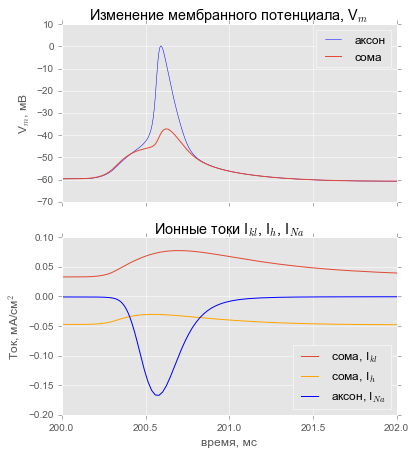

In [20]:
# pic ПД, somatic Ih, Ikl, axonic Ina -- time

f, axs = subplots(2,1,sharex=True, figsize=(6,7),)

axs[1].plot(som['t'], som['klt'], '-', label=u'сома, I$_{kl}$')
# axs[0].plot(som['t'], som['kht'], '-', label=u'сома, I$_{klt}$')
axs[1].plot(som['t'], som['h'], '-',color='orange', label=u'сома, I$_h$')
# axs[1].plot(som['t'], som['leak'], '-', color='orange', label=u'сома, I$_{leak}$')
axs[1].plot(ax['t'], ax['na'], 'b-', label=u'аксон, I$_{Na}$')
# axs[1].plot(ax['t'], ax['leak'], 'c--', label=u'аксон, I$_{leak}$')
axs[1].legend(loc=4)
axs[1].set_title(u'Ионные токи I$_{kl}$, I$_h$, I$_{Na}$')
axs[1].set_ylabel(u'Ток, мА/см$^2$')
axs[1].set_xlabel(u'время, мс')

axs[0].plot(traj['t'], traj['axon.v'],'b-',lw=0.5,label=u'аксон')
axs[0].plot(traj['t'], traj['soma.v'],'-',label=u'сома')
axs[0].legend()
axs[0].set_title(u'Изменение мембранного потенциала, V$_m$')
axs[0].set_ylabel(u'V$_m$, мВ')
xlim(200,202)
# f.savefig(u'AP_Currents2.pdf')

### Посчитать энергозатраты на емкостные токи

In [21]:
capacitance = soma.cm
dn_cap_e = dendrites[1](.5).i_cap*4*201*capacitance # 201 segments
sm_cap_e = soma.i_cap*capacitance
ax_cap_e = (ax_init.i_cap + ax_stub.i_cap)*capacitance
print dn_cap_e, sm_cap_e, ax_cap_e

-0.00043474204808 -9.9346967676e-06 0.000105885894775


In [17]:
# Определим Rin по проводимостям. С разделением Ih получается то же самое (?)
    # ***Стоит попробовать метод, предлагаемый в книге Стерратта для распределенных моделей***

def Rins(seg, Rin_from_literature=0):
    gnar = seg.ina/(seg.v-seg.ena) # Siemens/cm^2
    gkr = seg.ik/(seg.v-seg.ek)
    ghr = seg.i_hcno/(seg.v-seg.eh_hcno)
    glkr = seg.i_leak/(seg.v-seg.erev_leak)

#     Rin_o = 6.7 # MOhm, Bal & Oertel, 2001 (mice); 15.8 MOhm, Bal & Baydas, 2009 (cat)
    # From model:
    Ginx = (gnar + gkr + ghr + glkr)* seg.area()*1e-8
    Rin_ox = 1e-6/Ginx
    return Rin_ox

In [22]:
# Найти индекс элемента в array, значение которого является наиближайшим к val
def find_nearest(array, value):
    idx = np.abs(array - value).argmin()
    return idx

In [23]:
# Отношение энергозатрат при активации к энергозатратам в покое
# start, stop -- пределы интегрирования/суммирования (по времени)
# delta -- отступ от start (время) -- для расчета энергозатрат в покое
# data -- что интегрировать

def active_to_rest_e(data, start, stop, delta):

    mi_a = find_nearest(data['t'], start) # Находим индексы, соответствующие start
    ma_a = find_nearest(data['t'], stop) # и stop.
    x = find_nearest(data['t'], start-delta) # Индекс, откуда считаются энергозатраты в покое. 
#     Можно же считать покой просто от start! Да. Однако, если мы хотим считать активацию 
#     не из V=Vrest, следует указать отступ (delta) от start, в котором будет расчитываться
#     покой (энергозатраты в момент времени start-delta, умноженные на stop-start). Delta --
#     такое, что при t=start-delta, V=Vrest.
    energies = {'rest':[], 'active':[]}
    
    rest_e_dend = 1e-3*data['dend.erate'][x]*(stop-start) # 1e-3 => [ms -> s]
    rest_e_axon = 1e-3*data['axon.erate'][x]*(stop-start)
    rest_e_soma = 1e-3*data['soma.erate'][x]*(stop-start)
    
    synaptic_e = 1e-3*trapz(data['syn.erate'][mi_a:ma_a], data['t'][mi_a:ma_a])
    active_e_dend = 1e-3*(trapz(data['dend.erate'][mi_a:ma_a], data['t'][mi_a:ma_a]) + trapz(data['syn.erate'][mi_a:ma_a], data['t'][mi_a:ma_a]))
    active_e_axon = 1e-3*trapz(data['axon.erate'][mi_a:ma_a], data['t'][mi_a:ma_a])
    active_e_soma = 1e-3*trapz(data['soma.erate'][mi_a:ma_a], data['t'][mi_a:ma_a])
    
    rest_e_tot   = rest_e_dend+ rest_e_axon + rest_e_soma
    active_e_tot = active_e_dend + active_e_axon + active_e_soma
    
    energies['rest'] = [rest_e_tot, rest_e_soma, rest_e_dend, rest_e_axon]
    energies['active'] = [active_e_tot, active_e_soma, active_e_dend, active_e_axon, synaptic_e]
    
#     нижнее -- без учета токов аксона
#     rest_e   = 1e-3*(data['soma.erate'][x]*(stop-start) + data['dend.erate'][x]*(stop-start) + data['syn.erate'][x]*(stop-start))
#     active_e = 1e-3*(trapz(data['soma.erate'][mi_a:ma_a], data['t'][mi_a:ma_a]) + trapz(data['dend.erate'][mi_a:ma_a], data['t'][mi_a:ma_a]) + trapz(data['syn.erate'][mi_a:ma_a], data['t'][mi_a:ma_a]))

    ratio = active_e_tot/rest_e_tot
    return ratio, energies

def active_to_rest_e2(data, cape, start, stop, delta):

    mi_a = find_nearest(data['t'], start) # integration lims
    ma_a = find_nearest(data['t'], stop)
    x = find_nearest(data['t'], start-delta)
    energies = {'rest':[], 'active':[]}

    r_total_h = 1e-3*data['tot_h.erate'][x]*(stop-start)
    r_soma_h = 1e-3*data['soma_h.erate'][x]*(stop-start)
    r_dend_h = 1e-3*data['dends_h.erate'][x]*(stop-start)

    r_total_klt = 1e-3*data['tot_klt.erate'][x]*(stop-start)
    r_soma_klt = 1e-3*data['soma_klt.erate'][x]*(stop-start)
    r_dend_klt = 1e-3*data['dends_klt.erate'][x]*(stop-start)
    
    a_total_h = 1e-3*trapz(data['tot_h.erate'][mi_a:ma_a], data['t'][mi_a:ma_a])
    a_soma_h =  1e-3*trapz(data['soma_h.erate'][mi_a:ma_a], data['t'][mi_a:ma_a])
    a_dend_h =  1e-3*trapz(data['dends_h.erate'][mi_a:ma_a], data['t'][mi_a:ma_a])
    
    a_total_klt = 1e-3*trapz(data['tot_klt.erate'][mi_a:ma_a], data['t'][mi_a:ma_a])
    a_soma_klt = 1e-3*trapz(data['soma_klt.erate'][mi_a:ma_a], data['t'][mi_a:ma_a])
    a_dend_klt = 1e-3*trapz(data['dends_klt.erate'][mi_a:ma_a], data['t'][mi_a:ma_a])
    
    cape_soma = 1e-3*trapz(cape['soma_cape'][mi_a:ma_a], cape['t'][mi_a:ma_a])
    cape_ax = 1e-3*trapz(cape['ax_cape'][mi_a:ma_a], cape['t'][mi_a:ma_a])
    cape_dend = 1e-3*trapz(cape['dend_cape'][mi_a:ma_a], cape['t'][mi_a:ma_a])
    
    
    energies['rest'] = [r_total_h, r_total_klt, r_soma_h, r_soma_klt, r_dend_h, r_dend_klt]
    energies['active'] = [a_total_h, a_total_klt, a_soma_h, a_soma_klt, a_dend_h, a_dend_klt]
    
    return  energies, cape_soma, cape_ax, cape_dend

In [24]:
def e_calc(start, stop, delta, order='ordered'):
    data, h_klt, cape = go_tmp(add_synapses(order))
    ratio, energies = active_to_rest_e(data, start, stop, delta)
    energies_h_klt, a,b,c = active_to_rest_e2(h_klt, cape, start, stop, delta)
    factor = 1000/(stop-start)
    print\
    """                  Покой: {:.3e}
              Активация: {:.3e}
Соотношение Актив/Покой: {:.3e}""".format(energies['rest'][0]*factor, energies['active'][0]*factor, ratio)
    return ratio, energies, energies_h_klt,a,b,c


In [24]:
ratio, energies = active_to_rest_e(traj, 200, 203, 50)

In [25]:
print energies['rest'][0]*333.3, energies['active'][0]*333.3

224.139003191 296.192241902


In [43]:
# То, что в дипломе!!! Сейчас ПД Другой!! (см  пред ячейку )
# 1 ПД интегр за 3 мс.
ratio, energies, h_klt,a,b,c, = e_calc(200,203, 50)

                  Покой: 2.240e+02
              Активация: 2.909e+02
Соотношение Актив/Покой: 1.299e+00


In [345]:
# 1 ПД интегр за 1 мс.
ratio, energies, h_klt,a,b,c, = e_calc(200,201, 50)

                  Покой: 2.242e+02
              Активация: 4.324e+02
Соотношение Актив/Покой: 1.929e+00


In [346]:
# 1 ПД интегр за 0.8 мс.
ratio, energies, h_klt,a,b,c, = e_calc(200.2,201, 50)

                  Покой: 2.242e+02
              Активация: 4.780e+02
Соотношение Актив/Покой: 2.132e+00


In [347]:
# 1 спайк ПД интегр за 0.3 мс.
ratio, energies, h_klt,a,b,c, = e_calc(200.5,200.8, 50)

                  Покой: 2.242e+02
              Активация: 6.908e+02
Соотношение Актив/Покой: 3.081e+00


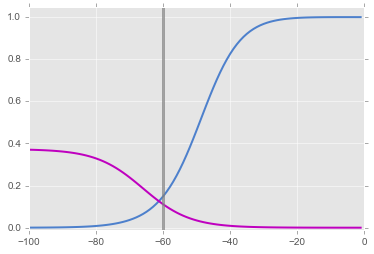

In [27]:
# График: зависимости проводимостей Gkl, Gh от Vm; нормированы на максимальную Gkl.
def plot_g(section, potentials):
    conds = {'h':[],'klt':[]}
    for v in potentials:
        h.finitialize(v)
        conds['h'].append(section.thegna_hcno)
        conds['klt'].append(section.g_kltoz)
    h_norm = array(conds['h'])/conds['h'][0]
    h_norm_to_klt = array(conds['h'])/conds['klt'][99]
    klt_norm = array(conds['klt'])/conds['klt'][99]
    
    fig = plot(potentials, klt_norm, color=(0.3,0.5,0.8), lw=2)
    plot(potentials, h_norm_to_klt, 'm-', lw=2)
#     plot(potentials, h_norm, 'm-', lw=2)
    axvline(-60, color='grey', lw=3, alpha=0.7)
    ylim(-0.01,1.05)
    
    return conds, fig

v = arange(-100,0)
conds, fig = plot_g(soma, v)
# savefig('h_and_klt_conductances2.pdf')